In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from cycler import cycler
import scipy.interpolate
import matplotlib.ticker as mticker
import time
from scipy.optimize import curve_fit
import math
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [4]:
def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges = np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass
        
    return bins_edges, bins_centers,  y_stackable

In [5]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [6]:
#Hirano 2014
pathfit_Hirano2014 = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2014/'
name_Hirano2014 = ['Total', 'Bins']
Hirano2014 = np.empty(len(name_Hirano2014), dtype=object)
Nbins_Hirano2014 = 26
for i in range(len(name_Hirano2014)):
    Hirano2014[i] = np.genfromtxt(pathfit_Hirano2014 + name_Hirano2014[i] +'.csv', delimiter=';')

Bins_Hirano2014_min = Hirano2014[-1][0][0]
Bins_Hirano2014_max = Hirano2014[-1][1][0]
Bins_limit_Hirano2014=(9.9, 1700)

Hirano2014_edges, Hirano2014_centers, Hirano2014_Y = DataStack(Hirano2014, Nbins_Hirano2014)

In [7]:
Hirano2014_centers_fitted, Hirano2014_Y_fitted, Err_H2014 = LogGaussianfit(Hirano2014_centers, Hirano2014_Y, (0.3,1), (1,3))

NameError: name 'LogGaussianfit' is not defined

array([   7.45205192,    9.20939506,   11.38115493,   14.06505928,
         17.38188205,   21.48087808,   26.5464995 ,   32.80669594,
         40.54317212,   50.10406439,   61.91960661,   76.5214904 ,
         94.56679094,  116.86753488,  144.42724104,  178.48607807,
        220.57667124,  272.59306956,  336.87597676,  416.31808137,
        514.49422587,  635.82227219,  785.76190264,  971.06030198,
       1200.05577633, 1483.05297144])

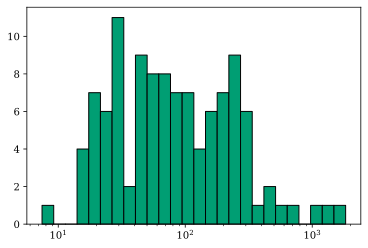

In [ ]:
plt.bar(Hirano2014_edges[:-1], Hirano2014_Y, width=np.diff(Hirano2014_edges), ec="k", align="edge")
# plt.plot(Hirano2014_centers_fitted, Hirano2014_Y_fitted)

plt.xscale('log')
Hirano2014_edges[:-1]

In [ ]:
#Stacy 2013
def Stacy2013(M, M_min, M_max):
    IMF = M**(-0.17)
    N = integrate.quad(lambda M: IMF, M_min, M_max, epsrel=1e-4)[0]
    return IMF/N

In [ ]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)


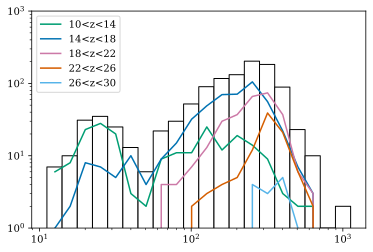

In [ ]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

No handles with labels found to put in legend.


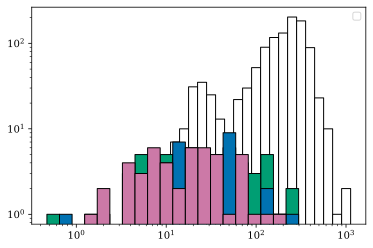

In [ ]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(len(Susa_Y)):
    plt.bar(Susa_edges[i][:-1], Susa_Y[i], width=np.diff(Susa_edges[i]), ec="k", align="edge")   
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [8]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)
print(x_bins, N_per_halos)


[1 2 3 4 5 6] [21. 11. 14.  8.  1.  4.]


In [9]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

In [10]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

Text(0, 0.5, 'Number of halo')

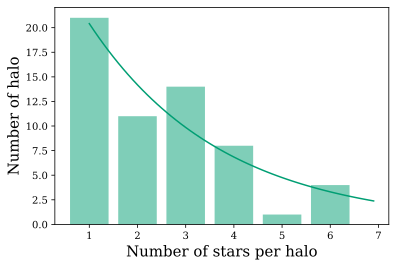

In [11]:
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

In [12]:
N_per_halos_z30 = np.array([0.8, 0.2, 0., 0., 0., 0.])
popt30, pcov30 = curve_fit(PowerLaw, x_bins, N_per_halos_z30,  bounds=([18, 0], [30, 10]))
y_fit_NH_30 = PowerLaw(x_fit_NH, *popt30)

A30, a30 = popt30

In [13]:
def PowerLaw_norm(x, A, a):
    N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
    return A*np.exp(-x*a)


In [14]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_z10 = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_z10,  bounds=([0, 0], [30, 10]))
y_fit_NH_10 = PowerLaw(x_fit_NH, *popt10)

A10, a10 = popt10

Text(0, 0.5, 'Number of halo')

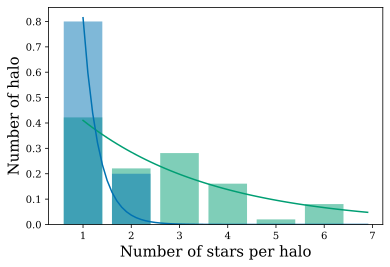

In [15]:

y_fit_norm = y_fit_NH/N_NH

plt.plot(x_fit_NH, y_fit_NH_10, color=myColors[0])
plt.bar(x_bins, N_per_halos_z10, alpha = 0.5)
plt.bar(x_bins, N_per_halos_z30, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH_30, color=myColors[1])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')


In [16]:
def Az(z):
    # A_int = scipy.interpolate.UnivariateSpline((10, 30),(A10, A30))
    A_int =  scipy.interpolate.krogh_interpolate((10, 30),(A10, A30), z)
    return float(A_int)

def az(z):
    # a_int = scipy.interpolate.UnivariateSpline((10, 30),(a10, a30))
    a_int =  scipy.interpolate.krogh_interpolate((10, 30),(a10, a30), z)
    return float(a_int)

def PowerLaw_PDF_Z(n_s, z):
    def PowerLaw_z(n_s, z):
        A = Az(z)
        a = az(z)
        N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
        return A*np.exp(-n_s*a)/N_NH
    v= np.vectorize(PowerLaw_z)
    return v(n_s, z)

In [17]:
n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

x, y = np.meshgrid(n_s, z)

pl = np.array(PowerLaw_PDF_Z(x, y))

N_star_prob = scipy.interpolate.interp2d(n_s, z, pl, kind='cubic')

In [18]:
def N_star_pdf(n_s, z):
    n = np.vectorize(N_star_prob)
    return n(n_s, z)

Text(0, 0.5, '$P(N_*)$')

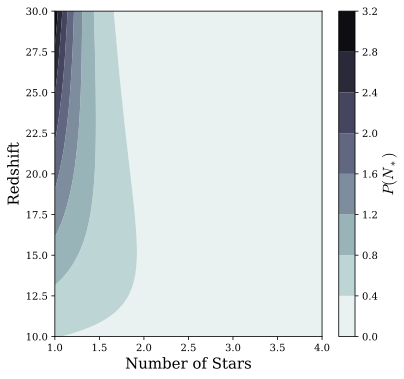

In [19]:
fig1, ax2 = plt.subplots(figsize=(6 , 6))

origin = 'lower'

n_s = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

CS = ax2.contourf(n_s, z, N_star_prob(n_s, z), cmap=plt.cm.bone_r, origin=origin)

ax2.set_xlabel('Number of Stars')
ax2.set_ylabel('Redshift')
ax2.set_xlim(1, 4)

# CS2 = ax2.contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')

# cbar.add_lines(CS2)

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

In [20]:
from PS_class import HaloMassFunction

In [21]:
HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

gen = np.random.default_rng()

H_IMF = HMF.IMF

z = np.linspace(10, 30, 100)
Mh_interval=(10**4, 10**10)
m = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)

In [22]:
xh, yh = np.meshgrid(m, z)

h = H_IMF(xh, yh)

In [23]:
h_inter = scipy.interpolate.interp2d(m, z, h, kind='cubic')

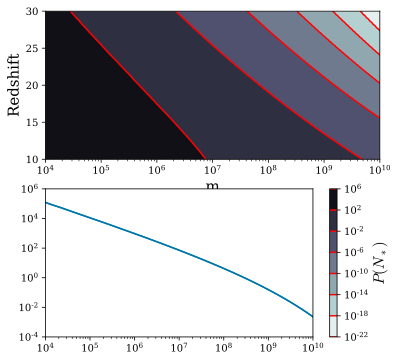

In [24]:
fig1, ax2 = plt.subplots(2, figsize=(6 , 6))

origin = 'lower'

CS = ax2[0].contourf(m, z, h_inter(m,z), cmap=plt.cm.bone_r, origin=origin, locator=mpl.ticker.LogLocator())

ax2[0].set_xlabel('m')
ax2[0].set_xscale('log')
ax2[0].set_ylabel('Redshift')
CS2 = ax2[0].contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')
m2 = np.logspace(4, 15, 100)
ax2[1].plot(m2, h_inter(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].plot(m2, H_IMF(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')

ax2[1].set_ylim(1e-4,1e6)
ax2[1].set_xlim(1e4,1e10)

cbar.add_lines(CS2)

In [25]:
def halo_PDF_norm(z):
    return integrate.quad(h_inter, Mh_interval[0], Mh_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]

halo_PDF_norm(11)

7322122484.518658

In [479]:
from PS_class import GrowthFunction

GF = GrowthFunction()

In [499]:
from PS_class import Overdensities
O=Overdensities(0)

def derivative(M):
        sigma = O.S(M)
        sigma_plus = O.S(1.000000001*M)
        return (sigma_plus-sigma)/(0.000000001*M)

def M_finder(M0, sigma):
        return float(scipy.optimize.fsolve(lambda x: O.S(x)-sigma, M0))

m_finder =np.vectorize(M_finder)
        
def S_for_M(M, sigma_MF):
    return O.S(M)-sigma_MF

In [500]:
def HalosGenerator(ninput, z):
    r = np.random.uniform(0, 1, ninput)
    y = GF.D_of_z(z)/(np.sqrt(2))/scipy.special.erfinv(r)
    M=m_finder(1e4, y)
    return M


In [501]:
n_halos=1000

Halos = HalosGenerator(n_halos, 10)

/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PS_class.py:170: RuntimeWarning: invalid value encountered in double_scalars
  R = c*(m/(gamma_f*self.rho_0))**(1/3)
/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PS_class.py:171: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]


TypeError: '<' not supported between instances of 'complex' and 'float'

In [26]:
def HalosGenerator(ninput, z):

    norm = halo_PDF_norm(z)

    def pdf(m):
        return h_inter(m, z)/norm
    
    m_int = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)
    pdf_int = scipy.interpolate.interp1d(m_int, pdf(m_int))

    fmax=pdf_int(Mh_interval[0])+0.02*pdf_int(Mh_interval[0])
    x_output=np.array([])
    
    ii=0
    t=[]
    while ii<ninput:

        # t0 = time.time()
        # t.append(time.time()-t0)

        x = gen.uniform(*Mh_interval, 10000)
        y = gen.uniform(0, fmax, 10000)

        x_accepted = x[(y <= pdf_int(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        print('halos', ii)

        

        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    
    return x_output[:ninput]



In [486]:
n_halos=1000

Halos = HalosGenerator(n_halos, 10)

/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PS_class.py:170: RuntimeWarning: invalid value encountered in double_scalars
  R = c*(m/(gamma_f*self.rho_0))**(1/3)
/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PS_class.py:171: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]


TypeError: '<' not supported between instances of 'complex' and 'float'

In [472]:
Halos

array([1.17638143e+06, 2.22345000e+06, 5.75747738e+04, 3.08120312e+07,
       2.49814456e+04, 3.36414814e+04, 3.96096342e+04, 4.16861965e+04,
       3.30404885e+04, 2.87179467e+05, 1.72184940e+05, 5.48602146e+05,
       8.13673477e+06, 3.36491280e+06, 9.81361537e+05, 2.38053597e+07,
       1.56481836e+07, 1.45892887e+05, 5.24435608e+04, 3.40680622e+07,
       7.09050065e+06, 1.22469577e+04, 3.52796201e+05, 2.23432664e+05,
       1.14790779e+04, 3.46356299e+04, 1.50457882e+05, 6.44056016e+04,
       4.16344970e+05, 1.25268530e+06, 4.16251822e+09, 1.02277786e+08,
       2.14158922e+06, 1.77275576e+04, 9.85571262e+04, 6.85644721e+06,
       3.98771931e+09, 1.84680587e+06, 8.85425457e+07, 2.60318632e+05,
       8.00619865e+06, 5.57097367e+05, 1.18956140e+07, 4.10698181e+04,
       6.88653558e+08, 4.40168555e+04, 2.88644434e+04, 2.52310237e+04,
       2.62436413e+06, 5.23862343e+06, 8.62741464e+06, 3.17129736e+07,
       1.29193921e+06, 2.43312443e+06, 2.31544709e+06, 1.04695398e+04,
      

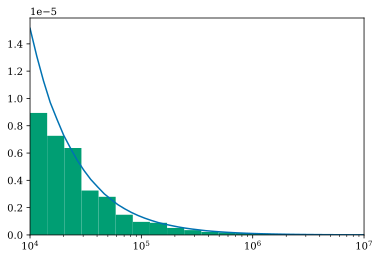

In [471]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 10, 40))
halo_PDF_norm_11 = halo_PDF_norm(11)
M=np.logspace(4, 10, 100)
plt.plot(M, h_inter(M, 11)/halo_PDF_norm_11)
plt.xlim(10**4, 10**7)
plt.xscale('log')

In [32]:
def N_StarGenerator(m_Hs, z):

    fmax=N_star_pdf(1, z)+0.02*N_star_pdf(1, z)
    x_output=np.array([])
    y_output=np.array([])

    ninput=len(m_Hs)
    
    ii = 0
    t = []
    while ii<ninput:

        x = gen.uniform(1, 7, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= N_star_pdf(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        y_accepted = y[(y <= N_star_pdf(x, z))]
        y_output = (np.append(y_output, y_accepted)).flatten()
        ii+=len(x_accepted)
        # print('N_star', ii)

        x_output = x_output[:ninput]
        y_output = y_output[:ninput]
    
    return x_output, np.log10(m_Hs)/6*x_output, y_output

    


In [33]:
N_star = N_StarGenerator(Halos, 11)

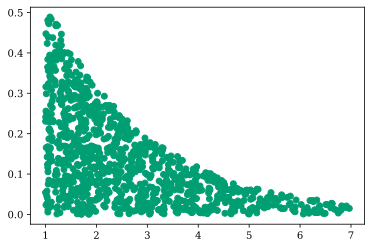

In [34]:
plt.scatter(N_star[0], N_star[2])

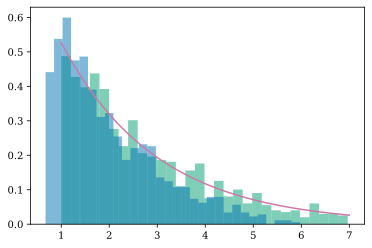

In [35]:
plt.hist(N_star[0], density=True, bins=30, alpha = 0.5)
plt.hist(N_star[1], density=True, bins=30, alpha = 0.5)
n_s=np.linspace(1, 7, 100)
plt.plot(n_s, N_star_prob(n_s, 11))

(array([0.7578, 0.54  , 0.    , 0.3096, 0.    , 0.135 , 0.    , 0.0486,
        0.009 ]),
 array([1.        , 1.55555556, 2.11111111, 2.66666667, 3.22222222,
        3.77777778, 4.33333333, 4.88888889, 5.44444444, 6.        ]),
 <a list of 9 Patch objects>)

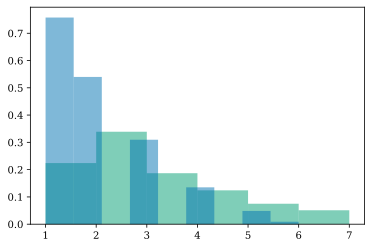

In [36]:
N_star_int_scaled = np.rint(N_star[1])[N_star[1]<11]
N_star_int_scaled = N_star_int_scaled[N_star_int_scaled<11]
N_star_int = np.rint(N_star[0])
N_star_int = N_star_int[N_star_int<11]

plt.hist(N_star_int, density=True, bins=6, alpha = 0.5)
plt.hist(N_star_int_scaled, density=True, bins=9, alpha = 0.5)

In [37]:
def Gaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * s**2))

In [38]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['Bins edges', 'Hist']

Susa = np.genfromtxt(pathfit_susa + name_susa[1] +'.csv', delimiter=';')
Bins_limit_Susa=np.genfromtxt(pathfit_susa + name_susa[0] +'.csv', delimiter=';')[:,0].tolist()
Nbins_Susa = 20
Bins_limit_Susa

[0.464926482, 295.3916929]

In [39]:
def HistMaker(bar_edges, bar_centers, bar_Y):
    data = []
    for i in range(len(bar_edges)-1):
        ii=1
        l1= len(data)
        while ii<=bar_Y[i]:
            data.append(np.log10(bar_centers[i]))
            ii+=1
        l2 = len(data)
        # print(l2-l1, bar_Y[i], np.array(data)[l1:l2])
    return data, 


In [40]:
Susa_edge, Susa_center, Susa_Y = RescalingCenters(Susa, Nbins_Susa, Bins_limit=Bins_limit_Susa)
Data_Susa_i = HistMaker(Susa_edge, Susa_center, Susa_Y)

No handles with labels found to put in legend.


[0.52420984 1.38007314]


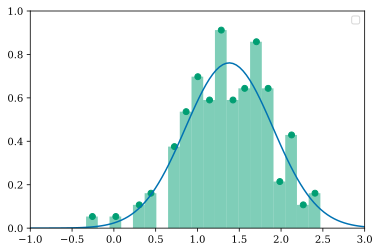

In [41]:
mfit_pop3 = np.linspace(-1, 3, 100)
bin_entries, _, _  = plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True)   

mask=(Susa_Y!=0)
Susa_centerf = np.log10(Susa_center)[mask]
plt.scatter(np.log10(Susa_center)[mask], bin_entries[mask])

Susa_popt, Susa_pcov = curve_fit(Gaussian, Susa_centerf, bin_entries[mask], bounds=([0,0],[10, 2]))

plt.plot(mfit_pop3, Gaussian(mfit_pop3, *Susa_popt))
print(Susa_popt) 

plt.ylim(0, 1)
plt.xlim(-1, 3)
plt.legend()

In [42]:
def Susa_IMF_PDF(m, z):
    return Gaussian(np.log10(m), *Susa_popt)

def Susa_IMF_PDF_log(logm, z):
    """
    this pdf is normlaized only for the log of the mass!
    """
    return Gaussian(logm, *Susa_popt)


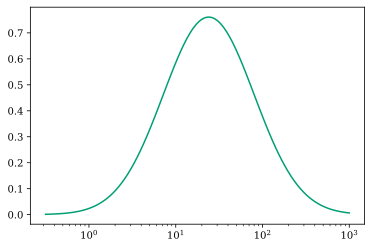

In [43]:
M=np.logspace(-0.5, 3, 100)
plt.plot(M, Susa_IMF_PDF(M, 10))
plt.xscale('log')

In [44]:
from scipy.stats import loguniform

def Mass_Star_Generator(ninput, z, PDF, logm_interval):
    m_max = np.logspace(logm_interval[0],  logm_interval[1], 100)
    pdfmax = np.max(PDF(m_max, z))
    fmax = pdfmax+0.02*pdfmax
    x_output = np.array([])
    y_output = np.array([])
    
    ii = 0
    while ii<ninput:

        x = loguniform.rvs(10**logm_interval[0], 10**logm_interval[1], size=ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        # print('Mass star', ii)

        x_output = x_output[:ninput]
    
    return x_output


In [46]:
star = Mass_Star_Generator(10000, 10, Susa_IMF_PDF, (-1, 3))

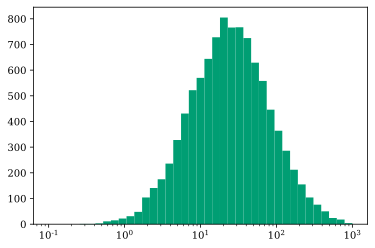

In [47]:
m = np.logspace(-1, 4, 100)
plt.hist(star, density=False, bins=10**np.linspace(-1,3,40))
# plt.plot(m, Susa_IMF_PDF(m, 10))
plt.xscale('log')

In [268]:
z=10
N_h = 100
Mass_Halos = HalosGenerator(N_h, 30)


<ipython-input-25-f3d7ffdc4a46>:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(h_inter, Mh_interval[0], Mh_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]


halos 0
halos 0
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1
halos 1


In [269]:
Star_system = np.empty(N_h, dtype=object)

N_star = N_StarGenerator(Mass_Halos, z)[1]

for i in range(len(N_star)):
    Star_system[i] = Mass_Star_Generator(int(round(N_star[i])), z, Susa_IMF_PDF, (-1, 3))

In [270]:
Star_system

array([array([34.53843784, 12.81573678,  6.16459015, 44.20256297, 32.85852146]),
       array([ 3.51626205,  2.70220287, 69.27826041]),
       array([4.39330368]), array([30.12934938]), array([29.8073368]),
       array([ 22.96425877, 455.65045895]),
       array([35.27288643,  5.4891931 ]), array([35.85611301]),
       array([48.70238355, 18.55622155, 43.37336677]),
       array([15.39876514]), array([97.2177764]),
       array([21.23059826, 25.95470426]),
       array([ 59.84136568, 377.54574892]), array([18.29153049]),
       array([8.51023807]),
       array([25.87919116, 71.5858921 , 14.12132889, 27.59425004, 25.77266938]),
       array([31.28839401, 63.64671408]),
       array([13.98913688, 12.52688816]),
       array([ 2.7865073 , 42.0505753 , 73.29362719]),
       array([39.72954792,  3.86600216, 19.02984734, 83.24352696]),
       array([32.17312211, 90.2141759 ]), array([0.71153362]),
       array([23.38875652, 13.85377233]), array([1.85470429]),
       array([238.46851393,  9

In [361]:
from colossus.cosmology import cosmology
from colossus.halo import profile_einasto

G=constants.G.to(u.kpc**3/u.kg/u.s**2)*constants.M_sun

print(G)

cosmology.setCosmology('planck18')
p_Einasto = profile_einasto.EinastoProfile(M=1e6, c=5., z=10., mdef = 'vir')

4.517103050001135e-39 kpc3 / s2


In [140]:
R = np.logspace(-5, 2, 100)
rho = p_Einasto.densityInner(R)

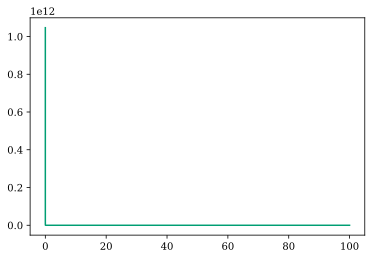

In [141]:
plt.plot(R, rho)
plt.xscale('log')
plt.yscale('log')

In [335]:
from scipy.optimize import bisect

def EinastoProfile(r, M, z):
    p_Einasto = profile_einasto.EinastoProfile(M=M, c=5., z=z, mdef = 'vir')
    return p_Einasto.densityInner(r)


def Einasto_CDF(r, profile, z):
    return profile.cumulativePdf(r, 1e2, z=z, mdef='vir')

def find_Einasto_icdf(p, cdf, profile, z):
    return bisect(lambda x: cdf(x, profile, z) - p, 0, 1e2)

def Einasto_icdf(u, profile, z):
    icdf = np.vectorize(lambda p: find_Einasto_icdf(p, Einasto_CDF, profile, z))
    return icdf(u)

p_Einasto = profile_einasto.EinastoProfile(M=1e6, c=5., z=10, mdef = 'vir')

Einasto_icdf(0.8, p_Einasto, 10)

array(1.06787108)

In [399]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x.tolist(), y.tolist(), z.tolist()]).T

In [459]:
def Star_infos_generator(M_halo, N_star, z):

    # if N_star>0:

    Einasto = profile_einasto.EinastoProfile(M=M_halo, c=5., z=z, mdef = 'vir')

    rs = Einasto.par['rs']

    Rmax=5*rs

    v_m = ((((6/5*G.value*M_halo/Rmax)**(1/2))*(u.kpc/u.s)).to(u.km/u.s))

    un = np.random.uniform(0, 1, N_star)


    r_output = (Einasto_icdf(un, Einasto, z)*rs).tolist()
    theta_output = np.random.uniform(0, np.pi, N_star).tolist()
    phi_output = np.random.uniform(0, 2*np.pi, N_star).tolist()
    thetav_output = np.random.uniform(0, np.pi, N_star).tolist()
    phiv_output = np.random.uniform(0, 2*np.pi, N_star).tolist()

    v=(Einasto.circularVelocity(r_output)).tolist()

    print(r_output)
    return spherical_to_cartesian(r_output, theta_output, phi_output), spherical_to_cartesian(v, thetav_output, phiv_output)
    
    # else:
    #     return [0], [0], [0], [0], [0], [0]
    

In [389]:
np.array([[1,2,3,4,5,6],[7,8,9,10,11,12], [13,14,15,16,17,18]]).T

array([[ 1,  7, 13],
       [ 2,  8, 14],
       [ 3,  9, 15],
       [ 4, 10, 16],
       [ 5, 11, 17],
       [ 6, 12, 18]])

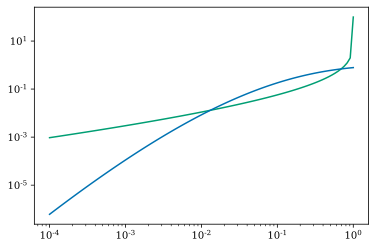

In [336]:
r=np.logspace(-4, 0, 100)
plt.plot(r, Einasto_icdf(r, p_Einasto, 10.))
plt.plot(r, Einasto_CDF(r, p_Einasto, 10.))
plt.xscale('log')

plt.yscale('log')

In [271]:
def Last_S_infos(M_stars, r_stars, theta_stars, phi_stars):

    def inf(x):
        return -np.sum(x*M_stars[0:-1])/M_stars[-1]

    r_stars.append(inf(r_stars))
    theta_stars.append(inf(theta_stars))
    phi_stars.append(inf(phi_stars))
    return r_stars, theta_stars, phi_stars    

In [455]:
import itertools

def Merging_Time(M1, M2, R1, R2, v1, v2):

    M1 = M1*constants.M_sun
    M2 = M2*constants.M_sun
    R1 = (R1*u.kpc).to(u.m)
    R2 = (R2*u.kpc).to(u.m)

    mu = M1*M2/(M1+M2)
    m = M1+M2
    nu = mu/m
    
    c=constants.c#).to(u.km/u.s))
    G=constants.G#.to(u.kpc**3/u.kg/u.s**2)*constants.M_sun).to(u.km**3/u.s**2)
    v=np.linalg.norm(v2-v1)*u.km/u.s
    r=(np.linalg.norm(R2-R1)).to(u.kpc)
    t = ((5/256) * c**5 * G * m /nu / v**8).to(u.Myr)
    print(t)
    return t

def Stars_Selection(System, X, V):

    n_system = len(System)
    l_iter = np.arange(0, n_system, 1)
    combinations = list(itertools.combinations(l_iter, 2))
    T_merge = np.empty(len(combinations), dtype=object)

    for i in range(len(combinations)):
        M1, M2 = System[combinations[i][0]], System[combinations[i][1]]
        R1, R2 = X[combinations[i][0]], X[combinations[i][1]]
        V1, V2 = V[combinations[i][0]], V[combinations[i][1]]
        T_merge[i] = Merging_Time(M1, M2, R1, R2, V1, V2)
        if T_merge[i].value<13e9:
            print('I got one')
        
    return T_merge

In [460]:
for i in range(N_h):
    infos = Star_infos_generator(Mass_Halos[i], int(round(N_star[i])), z)
    # print('there is ', int(round(N_star[i])), 'stars in this halos, and their mass are, ', Star_system[i])
    T_merge = Stars_Selection(Star_system[i], infos[0], infos[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [328]:
H0= cosmo.H(0) 
def Time_z(z):
    return (2/3/(1+z)**(3/2)/H0).to(u.Myr)

def Redshift_t(t):
    return ((3/2*t*H0.to(u.Myr**-1))**(-2/3)).value-1

print('The simulatation will start at $t_i=$', Time_z(30), 'and finish at $t_f=$', Time_z(10), '. There will be ' , int((Time_z(10)-Time_z(30)).value), 'steps')
t_i = Time_z(30)
t_f = Time_z(30)

def redhsift_steps(step_number):
    if step_number <= int((Time_z(10)-Time_z(30)).value):
        steped_time = t_i + step_number * u.Myr
        print(Redshift_t(steped_time))
        return Redshift_t(steped_time)
    else:
        print('The simulation is finished')
        return False
  
simulation_finished = False
for i in range(300):
    simulation_finished = redhsift_steps(i)
    if not simulation_finished:
        break

The simulatation will start at $t_i=$ 53.95289317758324 Myr and finish at $t_f=$ 255.25146967475638 Myr . There will be  201 steps
29.999999999999993
29.622770380203587
29.256811127053464
28.901592969892654
28.556620222830528
28.221428118534085
27.895580394742016
27.578667105782653
27.270302634816755
26.970123885490874
26.67778863424898
26.392974026769373
26.115375203920657
25.844704044307466
25.58068801193892
25.323069098830977
25.07160285347326
24.826057487073285
24.58621305035468
24.35186067444689
24.122801870075477
23.898847879855644
23.67981907901751
23.465544420358086
23.255860919629352
23.050613177940747
22.8496529380831
22.65283867197474
22.460035196692726
22.271113316787247
22.085949490787833
21.90442551999915
21.726428257854117
21.551849338245155
21.380584921392312
21.212535455931413
21.047605456017845
20.88570329234338
20.726740996055373
20.570634074651363
20.417301338997742
20.26666474069012
20.11864921903555
19.97318255699388
19.8301952454674
19.68962035537538
19.551393416